In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../"))

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import desc.io
from desc.backend import jnp, jit
from desc.equilibrium import Equilibrium
from desc.grid import ConcentricGrid
from desc.plotting import plot_1d
from desc.profiles import PowerSeriesProfile
from desc.transform import Transform

np.set_printoptions(precision=3, floatmode="fixed")
jnp.set_printoptions(precision=3, floatmode="fixed")

DESC version 0.5.0+45.g4fa53a4.dirty, using JAX backend, jax version=0.2.25, jaxlib version=0.1.76, dtype=float64
Using device: CPU, with 9.75 GB available memory


## Visualizing different grids

In [3]:
def print_grid(grid, stop=None):
    """
    Parameters
    ----------
    grid
        Prints nodes and spacing.
    stop : int
        Max number of nodes to print. Defaults to entire grid.
    """
    assert (
        len(grid.nodes) // grid.num_zeta
        == jnp.where(~jnp.isclose(grid.nodes[:, 2], 0))[0][0]
    )
    print(grid.L, grid.M, grid.N, grid.NFP, grid.sym, grid.node_pattern)
    print(grid.num_rho, grid.num_theta, grid.num_zeta)
    print("nodes", "             ", "spacing")
    if stop is None:
        stop = len(grid.nodes)
    for i, e in enumerate(zip(grid.nodes, grid.spacing)):
        a, b = e
        print(a, b)
        if i > stop:
            break


rng = np.random.default_rng()
L = rng.integers(low=1, high=100)
M = rng.integers(low=1, high=100)
N = rng.integers(low=1, high=100)
NFP = rng.integers(low=1, high=100)
sym = True if rng.integers(2) > 0 else False
random_grid = ConcentricGrid(L=L, N=N, M=M, NFP=NFP, sym=sym)
print_grid(random_grid, stop=15)

55 14 14 89 False jacobi
28 275 29
nodes               spacing
[0.004 0.000 0.000] [4.223e-02 2.805e+01 1.087e-02]
[0.015 0.000 0.000] [5.825e-02 1.403e+01 1.087e-02]
[0.015 3.142 0.000] [5.825e-02 1.403e+01 1.087e-02]
[0.030 0.000 0.000] [0.083 9.351 0.011]
[0.030 2.094 0.000] [0.083 9.351 0.011]
[0.030 4.189 0.000] [0.083 9.351 0.011]
[0.052 0.000 0.000] [0.107 7.013 0.011]
[0.052 1.571 0.000] [0.107 7.013 0.011]
[0.052 3.142 0.000] [0.107 7.013 0.011]
[0.052 4.712 0.000] [0.107 7.013 0.011]
[0.078 0.000 0.000] [0.130 5.611 0.011]
[0.078 1.257 0.000] [0.130 5.611 0.011]
[0.078 2.513 0.000] [0.130 5.611 0.011]
[0.078 3.770 0.000] [0.130 5.611 0.011]
[0.078 5.027 0.000] [0.130 5.611 0.011]
[0.110 0.000 0.000] [0.151 4.675 0.011]
[0.110 1.047 0.000] [0.151 4.675 0.011]


## Bulk flux surface averaging test
The tests pass. timeit also shows the _surface_sums no loop algorithm is faster.

In [4]:
@jit
def _surface_sums(surf_label, unique_append_upperbound, weights):
    """
    Parameters
    ----------
    surf_label : ndarray
        The surface label. Elements of a coordinate in the collocation grid.
        i.e. grid.nodes[:, 0]
    unique_append_upperbound : ndarray
        Sorted unique elements of surf_label with the upper bound of that coordinate appended.
        i.e. grid.unique_rho + [1]
    weights : ndarray
        Node at surf_label[i]'s contribution to its surface's sum is weights[i].
        For an integral, this could be: ds * function_to_integrate.

    Returns
    -------
    ndarray
        An array of weighted sums over each surface.
        The returned array has length = len(unique_append_upperbound) - 1.
    """
    # DESIRED ALGORITHM
    # collect collocation node indices for each rho surface
    # surfaces = dict()
    # for index, rho in enumerate(surf_label):
    #     surfaces.setdefault(rho, list()).append(index)
    # integration over non-contiguous elements
    # for i, surface in enumerate(surfaces.values()):
    #     surface_sums[i] = weights[surface].sum()

    # NO LOOP IMPLEMENTATION
    # Separate collocation nodes into bins with boundaries at unique values of rho.
    # This groups nodes with identical rho values.
    # Each is assigned a weight of their contribution to the integral.
    # The elements of each bin are summed, performing the integration.
    return jnp.histogram(surf_label, bins=unique_append_upperbound, weights=weights)[0]

In [5]:
function = np.random.random_sample(size=len(random_grid.nodes))

In [6]:
# %%timeit

iota_1 = np.zeros(random_grid.num_rho)
# DESIRED ALGORITHM
# collect collocation node indices for each rho surface
surfaces = dict()
for index, rho in enumerate(random_grid.nodes[:, 0]):
    surfaces.setdefault(rho, list()).append(index)
# integration over non-contiguous elements
for i, surface in enumerate(surfaces.values()):
    iota_1[i] = function[surface].sum()

In [7]:
# %%timeit

# NO LOOP IMPLEMENTATION
bins = jnp.append(random_grid.nodes[random_grid.unique_rho_indices, 0], 1)
iota_2 = _surface_sums(random_grid.nodes[:, 0], bins, function)
# bincount, bins = jnp.histogram(random_grid.nodes[:, 0], bins=bins)
# print(grid.nodes[random_grid.unique_rho_indices, 0])
# print(bincount)
# print(bins)

In [8]:
# must comment %%timeit to test assertion
print(iota_1)
print(iota_2)
assert jnp.allclose(iota_1, iota_2)

[ 14.659  30.721  40.286  65.371  78.219  84.329  99.386 111.184 131.747
 147.520 161.745 166.722 190.251 217.639 242.616 249.959 264.193 276.017
 284.992 289.618 313.016 340.726 353.724 359.885 358.089 389.258 413.120
 412.309]
[ 14.659  30.721  40.286  65.371  78.219  84.329  99.386 111.184 131.747
 147.520 161.745 166.722 190.251 217.639 242.616 249.959 264.193 276.017
 284.992 289.618 313.016 340.726 353.724 359.885 358.089 389.258 413.120
 412.309]


## Axisymmetric, vacuum, no current test
Want to test if the returned rotational transform profile is 0 when toroidal current input is 0.
This should be a good test because the bulk of the computation lies on enforcing the zero
toroidal current algorithm for the geometry of the device. And when a non-zero toroidal current is specified we just add it to the numerator because that is the delta poloidal flux term.

In [9]:
def get_concentric_grid(eq):
    """
    Parameters
    ----------
    eq : Equilibrium
        The equilibrium.

    Returns
    -------
    ConcentricGrid
        Concentric grid used by the given equilibrium.
    """
    return ConcentricGrid(
        L=eq.L_grid,
        M=eq.M_grid,
        N=eq.N_grid,
        NFP=1,
        sym=False,
        node_pattern=eq.node_pattern,
    )


def get_transform(eq, grid):
    """
    Parameters
    ----------
    eq : Equilibrium
        The equilibrium.
    grid : ConcentricGrid
        Concentric grid used by the given equilibrium.

    Returns
    -------
    Transform
         R_transform, Z_transform, L_transform of the given equilibrium.
    """
    from desc.compute import data_index

    r_derivs = jnp.vstack(data_index["sqrt(g)_rr"]["R_derivs"])
    l_derivs = jnp.vstack(
        (
            data_index["lambda_t"]["L_derivs"],
            data_index["lambda_rt"]["L_derivs"],
            data_index["lambda_rrt"]["L_derivs"],
            data_index["lambda_z"]["L_derivs"],
            data_index["lambda_rz"]["L_derivs"],
            data_index["lambda_rrz"]["L_derivs"],
        )
    )
    R_transform = Transform(grid, eq.R_basis, derivs=r_derivs, build=True)
    Z_transform = Transform(grid, eq.Z_basis, derivs=r_derivs, build=True)
    L_transform = Transform(grid, eq.L_basis, derivs=l_derivs, build=True)
    return R_transform, Z_transform, L_transform


def get_iota_data(eq, I_l, power_series):
    """
    Parameters
    ----------
    eq : Equilibrium
        The equilibrium.
    I_l : ndarray
        Coefficients of the current profile. (params of power_series).
    power_series : PowerSeriesProfile
        The power series to compute the toroidal current.

    Returns
    -------
    data : dict
        The dictionary which contains at least iota, iota_r, iota_rr.
    """
    from desc.compute._core import compute_rotational_transform_v2

    transform = get_transform(eq, power_series.grid)
    return compute_rotational_transform_v2(
        eq.R_lmn,
        eq.Z_lmn,
        eq.L_lmn,
        transform[0],
        transform[1],
        transform[2],
        eq.Psi,
        I_l=I_l,
        toroidal_current=power_series,
    )

In [10]:
torus = Equilibrium()
torus_I_l = jnp.zeros(2)
data = get_iota_data(
    torus,
    I_l=torus_I_l,
    power_series=PowerSeriesProfile(
        params=torus_I_l, modes=[0, 2], grid=get_concentric_grid(torus)
    ),
)
assert jnp.allclose(data["iota"], 0)

## Compare to VMEC test
Want to test if the rotational transform profile from new compute function matches the rotational transform profile computed by VMEC.

In [11]:
def plot(x, y, prepend_title):
    """
    Parameters
    ----------
    x : ndarray
        plot x-axis.
    y : ndarray
        plot y-axis. will make multiple plots if y.ndim > 1
    prepend_title : str
        string to prepend to plot title
    """
    dot_size = 5 if len(x) > 64 else 10
    y = np.atleast_2d(y)
    fig, ax = plt.subplots(ncols=y.shape[0], figsize=(y.shape[0] * 6.4, 4.8))
    ax = np.atleast_1d(ax)

    for i in range(y.shape[0]):
        append = " " + str(i) + " derivative wrt rho"
        ax[i].scatter(x, y[i, :], s=dot_size)
        ax[i].plot(x, y[i, :])
        ax[i].set(
            xlabel="rho",
            ylabel="iota" + append,
            yscale="symlog" if jnp.ptp(y[i, :]) > 1e3 else "linear",
            title=prepend_title + " iota" + append,
        )
        ax[i].grid()


def get_desc_plot(eq, params, modes):
    """
    Parameters
    ----------
    eq : Equilibrium
        The equilibrium.
    params : ndarray
        Coefficients of the current profile. (params of power_series).
    modes : ndarray
        Toroidal current power series profile modes.
        Should include only even modes to match VMEC AC input.

    Returns
    -------
    rho : ndarray
        unique rho values. x-axis of plot
    iotas : ndarray
        iota, iota_r, iota_rr at the unique rho values. y-axis of plot
    """
    grid = get_concentric_grid(eq)
    data = get_iota_data(
        eq,
        I_l=params,
        power_series=PowerSeriesProfile(params=params, modes=modes, grid=grid),
    )
    assert len(grid.nodes) == len(data["iota"])
    rho = grid.nodes[grid.unique_rho_indices, 0]
    iota = data["iota"][grid.unique_rho_indices]
    iota_r = data["iota_r"][grid.unique_rho_indices]
    iota_rr = data["iota_rr"][grid.unique_rho_indices]
    return rho, jnp.stack([iota, iota_r, iota_rr])


def get_vmec_plot(name):
    """
    Parameters
    ----------
    name : str
        Name of the equilibrium.

    Returns
    -------
    rho : ndarray
        rho values. x-axis of plot.
    iota : ndarray
        iota. y-axis of plot.
    """
    from netCDF4 import Dataset

    f = Dataset("edu_vmec/wout_" + name + ".nc")
    iota = jnp.asarray(f.variables["iotaf"])
    rho = jnp.sqrt(jnp.linspace(0, 1, len(iota)))
    return rho, iota

In [12]:
# values are toroidal current profiles (AC input for VMEC)
stellarators = {
    "SOLOVEV": jnp.array([4, -2, -1]),
    "DSHAPE": jnp.array([2, -3, 0]),
    "HELIOTRON": jnp.array([2, -2, -1]),
}

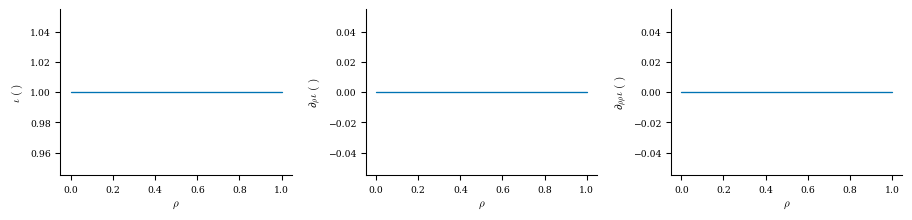

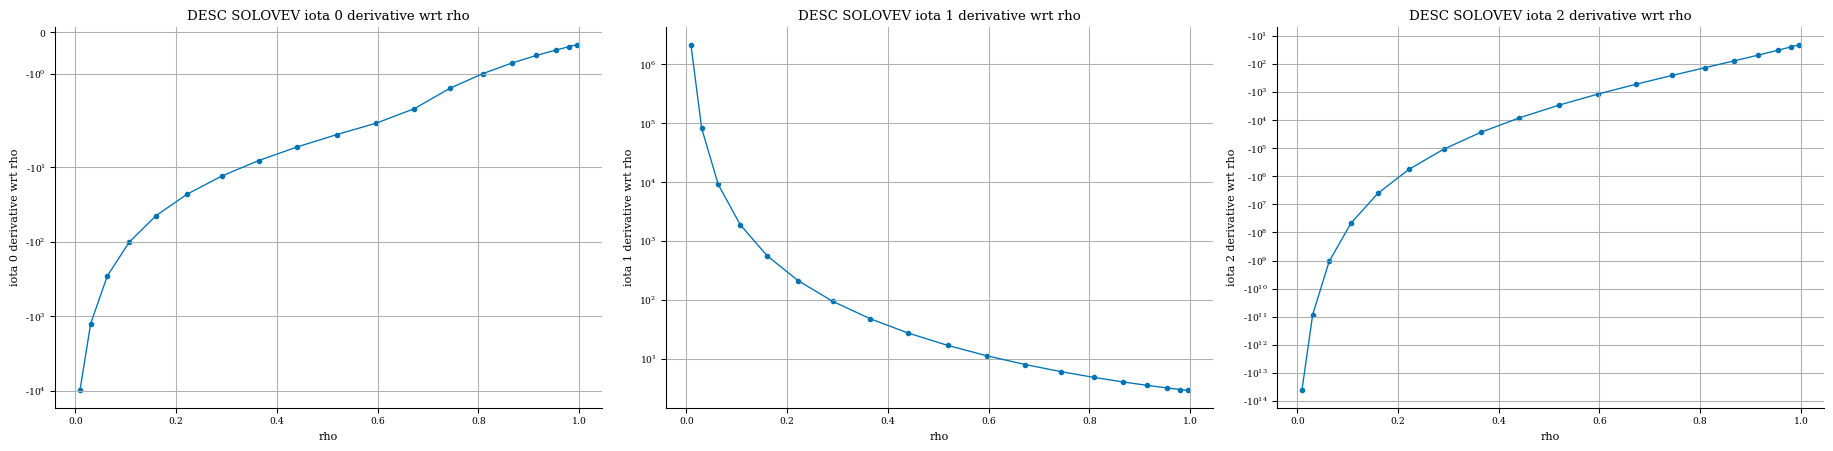

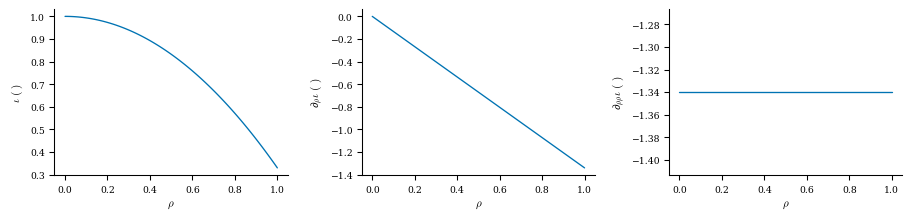

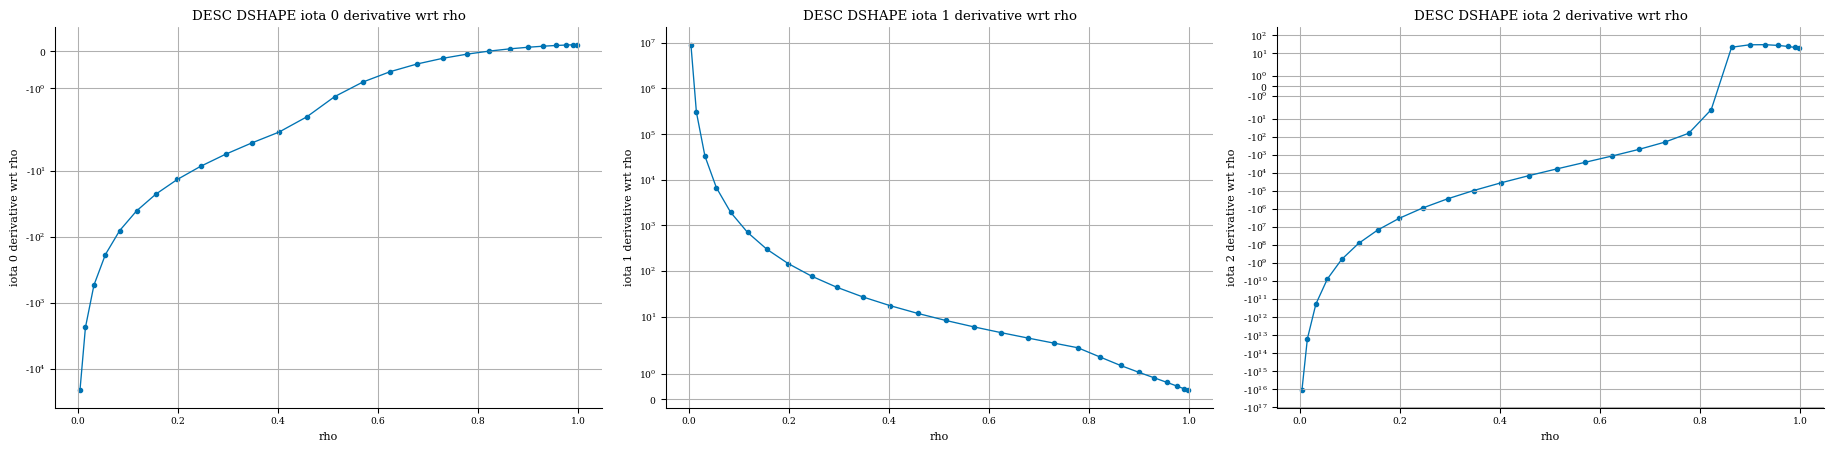

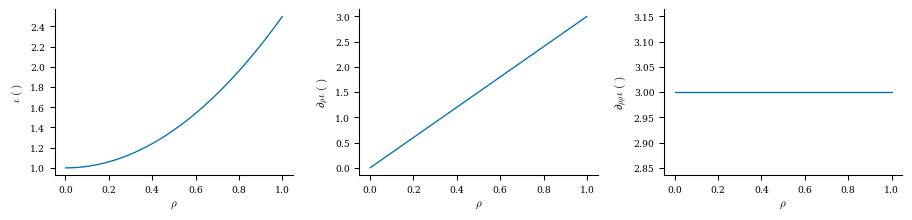

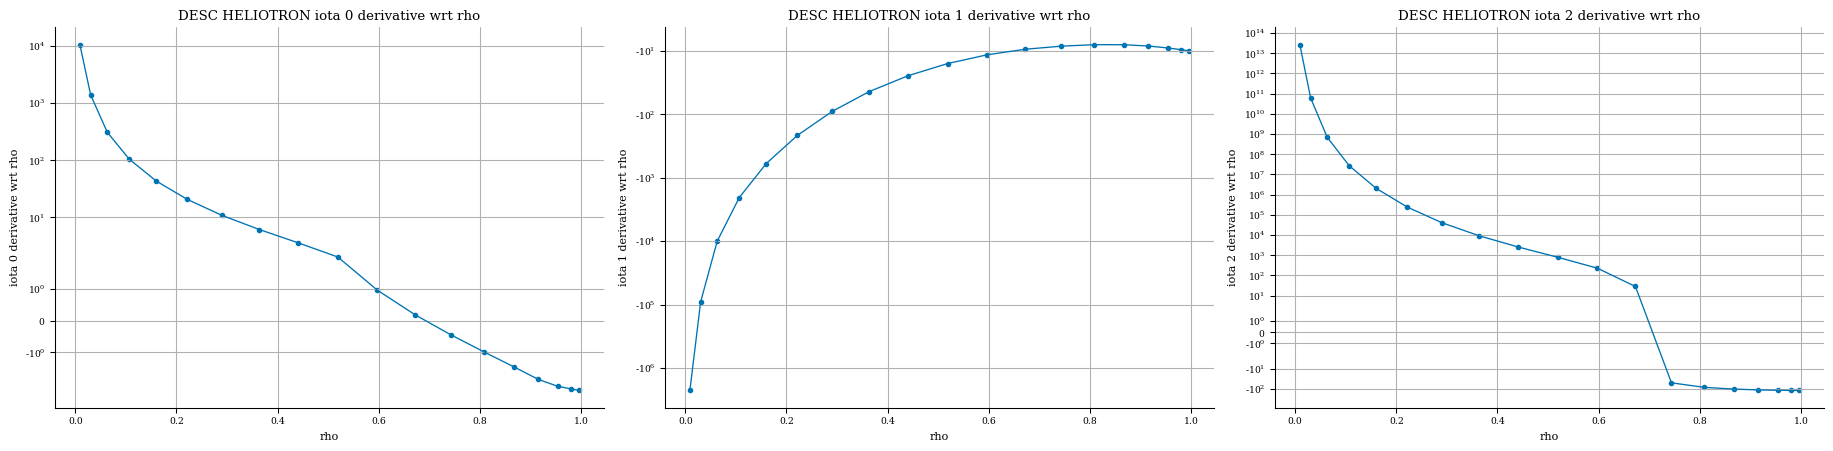

In [13]:
# plot DESC output
for name, params in stellarators.items():
    eq = desc.io.load("../examples/DESC/" + name + "_output.h5")[-1]
    # also plot iota from other rotational transform function
    fig, ax = plt.subplots(ncols=3, figsize=(3 * 3.2, 2.4))
    plot_1d(eq, "iota", ax=ax[0])
    plot_1d(eq, "iota_r", ax=ax[1])
    plot_1d(eq, "iota_rr", ax=ax[2])

    # modes are even to match VMEC psi modes
    rho, iota = get_desc_plot(eq, params, jnp.array([0, 2, 4]))
    plot(rho, iota, "DESC " + name)

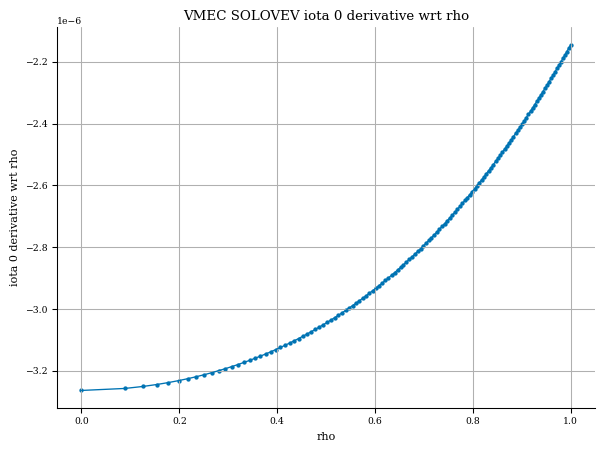

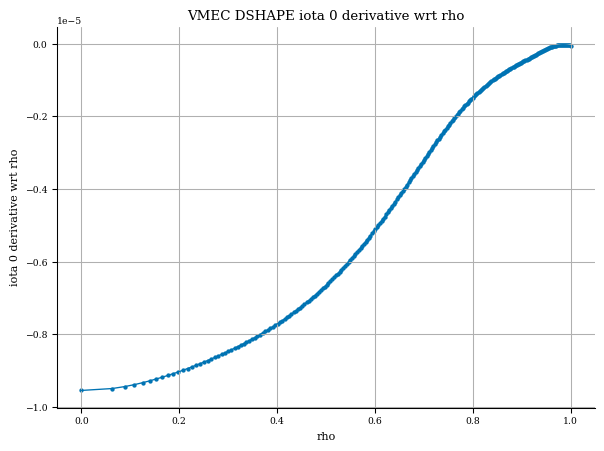

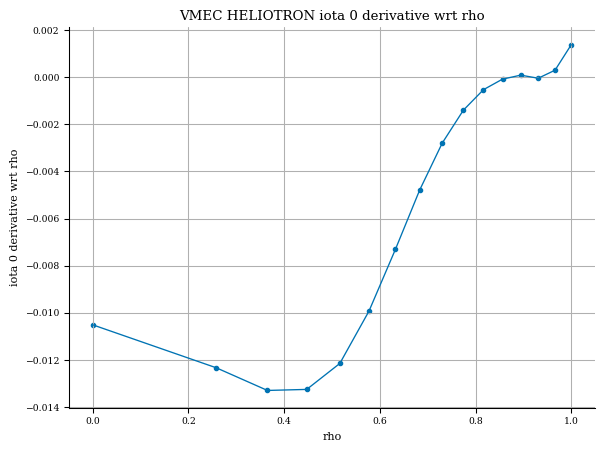

In [14]:
# plot VMEC output
for name in stellarators.keys():
    rho, iota = get_vmec_plot(name)
    plot(rho, iota, "VMEC " + name)